## Rollout Bayesian Optimization

In [5]:
using LinearAlgebra
using Plots
using Random

In [100]:
include("../rollout.jl")
include("../testfns.jl")

ConstantTestFunction (generic function with 2 methods)

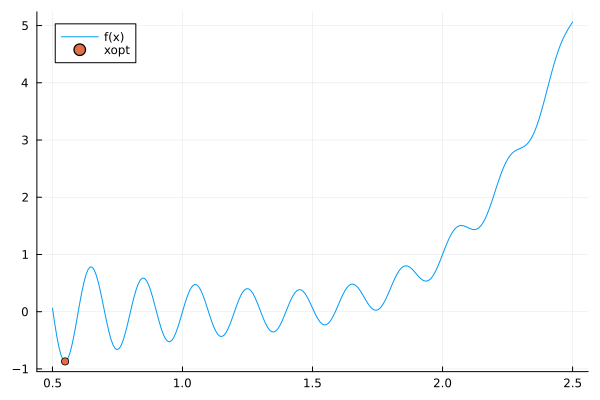

In [101]:
testfn = TestGramacyLee()
tplot(testfn)

### Dense Experiments in 1D for Rollout Acquisition Functions
We'll do a comparative analysis, visually, of the structure of the rollout acquisition function in 1D for horizons 0 and 1.

In [102]:
function sample_random_matrix(xmin, xmax, d, n)
    matrix = zeros(d, n)
    for i in 1:d
        for j in 1:n
            matrix[i, j] = xmin + (xmax - xmin) * rand()
        end
    end
    return matrix
end

sample_random_matrix (generic function with 1 method)

In [103]:
testfn = TestFunction(
    1, [0. 1.], [.5],
    x -> 0., # + σn2*randn(),
    ∇x -> [0.] # + σn2*randn()]
)

TestFunction(1, [0.0 1.0], [0.5], var"#6757#6759"(), var"#6758#6760"())

In [104]:
HORIZON = 0
MC_SAMPLES = 50
# Setup low discrepancy random number stream
lds_rns = gen_low_discrepancy_sequence(MC_SAMPLES, testfn.dim, HORIZON+1);
rns = randn(MC_SAMPLES, testfn.dim+1, HORIZON+1);

lbs = testfn.bounds[:, 1]
ubs = testfn.bounds[:, 2]
σn2 = 1e-6
θ = [.25]

ϵ, num_starts = 1e-6, 64
s = SobolSeq(lbs, ubs)

xstarts = reduce(hcat, next!(s) for i = 1:num_starts)
xstarts = hcat(xstarts, lbs .+ ϵ)
xstarts = hcat(xstarts, ubs .- ϵ);

ψ = kernel_matern52(θ)
Random.seed!(1906)
# X = sample_random_matrix(minimum(lbs), minimum(ubs), testfn.dim, 2)
X = [.15;; .85;;]
y = [testfn.f(X[:,j]) for j in 1:size(X, 2)]
sur = fit_surrogate(ψ, X, y; σn2=σn2);
# Probably makes sense to build this sequence internally and we can get rid of the
# assertion for making sure we received the correct sequence

In [107]:
domain = range(lbs[1], ubs[1], length=100)
domain = filter(x -> !(x in sur.X), domain)
ex = zeros(length(domain))
dex = zeros(length(domain))
stderrex = zeros(length(domain))

for (i, x) in enumerate(domain)
    tp = TrajectoryParameters(x0=[x], h=HORIZON, mc_iters=MC_SAMPLES, rnstream_sequence=rns, lbs=lbs, ubs=ubs)
    μ, ∇μ, stderr_μ, stderr_∇μ = simulate_trajectory(sur, tp, xstarts)
    dex[i] = first(∇μ)
    stderrex[i] = stderr_μ
    ex[i] = μ
end


Sampled Best Gradient: [-7.947937975978288]
Sampled Best Gradient: [-1.3901430344226577]
Sampled Best Gradient: [-0.5384340277822728]
Sampled Best Gradient: [-11.695580729176557]
Sampled Best Gradient: [2.800687395251241]
Sampled Best Gradient: [-4.712810424777143]
Sampled Best Gradient: [3.1464419937359813]
Sampled Best Gradient: [0.23419304896393126]
Sampled Best Gradient: [1.6694291942507486]
Sampled Best Gradient: [1.0902641917136342]
Sampled Best Gradient: [-4.768821961037213]
Sampled Best Gradient: [-8.634560486443501]
Sampled Best Gradient: [3.0222611333229175]
Sampled Best Gradient: [-7.367097146215493]
Sampled Best Gradient: [1.0276310456288587]
Sampled Best Gradient: [-6.1083824590384985]
Sampled Best Gradient: [2.4149341006462426]
Sampled Best Gradient: [-6.099117801728807]
Sampled Best Gradient: [4.783648450903989]
Sampled Best Gradient: [1.329833680406623]
Sampled Best Gradient: [-2.657518520489541]
Sampled Best Gradient: [-2.626343855244951]
Sampled Best Gradient: [0.2195

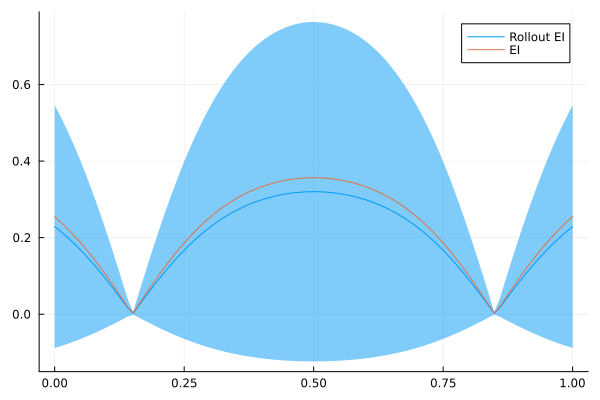

In [108]:
plot(domain, ex, label="Rollout EI", ribbons=stderrex)
plot!(domain, [sur([x]).EI for x in domain], label="EI")

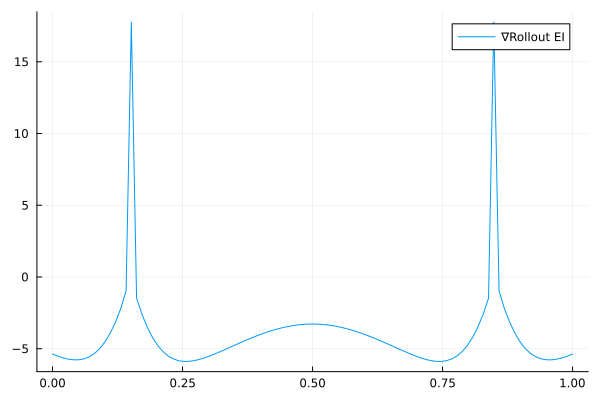

In [109]:
plot(domain, dex, label="∇Rollout EI")
# plot!(domain, [sur([x]).∇EI[1] for x in domain], label="∇EI")

In [55]:
deepcopy

deepcopy (generic function with 1 method)

In [112]:
sum(I(5), dims=1)

1×5 Matrix{Int64}:
 1  1  1  1  1

In [113]:
M = [2 3 4;
     4 6 10;]

2×3 Matrix{Int64}:
 2  3   4
 4  6  10

In [117]:
sum(M, dims=2) / 3

2×1 Matrix{Float64}:
 3.0
 6.666666666666667